In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge


In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 2  # Change this based on the number of classes in your dataset

# Load MobileNetV2 pre-trained on ImageNet
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224,3))


# Load VGG16 pre-trained on ImageNet
nasnet_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224,3))

# Freeze the layers in both models
for layer in mobilenet_model.layers:
    layer.trainable = False



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


In [ ]:
for layer in nasnet_model.layers:
    layer.trainable = False

# Combine MobileNetV2 and VGG16 models
input_tensor = Input(shape=(224, 224, 3))
mobilenet_output = mobilenet_model(input_tensor)
nasnet_output = nasnet_model(input_tensor)
combined_output = Concatenate()([mobilenet_output, nasnet_output])

# Add additional layers for classification
x = GlobalAveragePooling2D()(combined_output)
x = Dense(512, activation='relu')(x)
output_tensor = Dense(3, activation='softmax')(x)

# Create the combined model



In [ ]:
combined_model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
combined_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Display model summary
combined_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nasnet_large (Functional) │ (None, 7, 7, 4032)     │     84,916,818 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 7, 7, 5312)     │              0 │ mobilenetv2_1.00_224[… │
│ (Concatenate)             │                        │                │ nasnet_large[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 5312)           │              0 │ concatenate_4[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      2,720,256 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │          1,539 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 89,896,597 (342.93 MB)

 Trainable params: 2,721,795 (10.38 MB)

 Non-trainable params: 87,174,802 (332.55 MB)

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Use ImageDataGenerator for data augmentation and loading datasets
valid_path = '/content/drive/MyDrive/BreastCancer/Dataset/train/'
train_path = '/content/drive/MyDrive/BreastCancer/Dataset/test/'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# For binary classification, set class_mode='binary'
test_generator = test_datagen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, batch_size=16, class_mode='binary')
train_generator = train_datagen.flow_from_directory(train_path, target_size=IMAGE_SIZE, batch_size=16, class_mode='binary')




Found 797 images belonging to 3 classes.
Found 781 images belonging to 3 classes.


In [ ]:
# Train the model
history = combined_model.fit(train_generator, epochs=8, validation_data=test_generator)

Epoch 1/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - accuracy: 0.9030 - loss: 0.2451 - val_accuracy: 0.8657 - val_loss: 0.3652
Epoch 2/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 550ms/step - accuracy: 0.9487 - loss: 0.1451 - val_accuracy: 0.8256 - val_loss: 0.4726
Epoch 3/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.9436 - loss: 0.1515 - val_accuracy: 0.8745 - val_loss: 0.3554
Epoch 4/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 558ms/step - accuracy: 0.9316 - loss: 0.1527 - val_accuracy: 0.8758 - val_loss: 0.3950
Epoch 5/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.9380 - loss: 0.1473 - val_accuracy: 0.8607 - val_loss: 0.3985
Epoch 6/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 576ms/step - accuracy: 0.9497 - loss: 0.1289 - val_accuracy: 0.8745 - val_loss: 0.4046
Epoch 7/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 558ms/step - accuracy: 0.9205 - loss: 0.1901 - val_accuracy: 0.8858 - val_loss: 0.3588
Epoch 8/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 554ms/step - accuracy: 0.9456 - loss: 0.1367 - val_accuracy: 0.

In [ ]:
pred = combined_model.predict(test_generator)
print(pred)

50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 611ms/step
[[8.9934826e-01 1.0049371e-01 1.5798390e-04]
 [9.9999404e-01 5.8810128e-06 9.5033251e-08]
 [1.9114219e-02 7.9224621e-05 9.8080653e-01]
 ...
 [1.5034994e-04 1.7968850e-05 9.9983168e-01]
 [9.9999964e-01 3.2775603e-07 1.3195933e-09]
 [9.8086411e-01 1.9135714e-02 8.1691475e-08]]


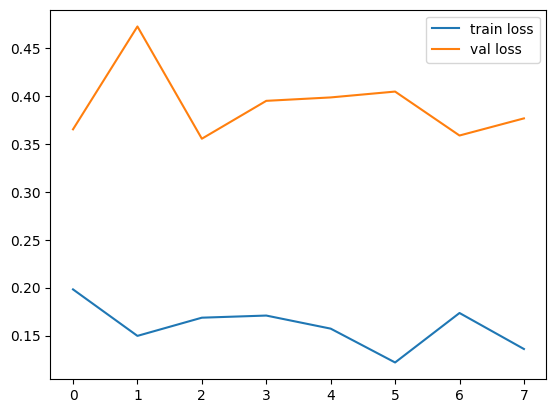

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

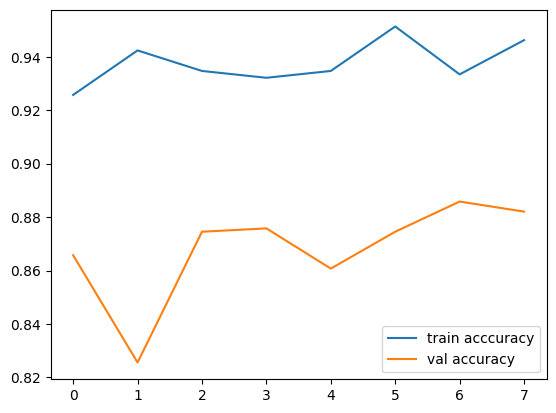

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train acccuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

In [ ]:
import os
import shutil
import numpy as np

origin = "//content//drive//MyDrive//BreastCancer//Dataset//test//benign//"
target1 = "//content//drive//MyDrive//BreastCancer//TestCheck//benign//"
files = os.listdir(origin)
actual=[]
predicted=[]
values=[]
imageName=[]
ac=[]
pr=[]
for file_name in files:
    print(origin+file_name)
    print(target1+file_name)
    shutil.copy(origin+file_name, target1+file_name)
    imageName.append(str(origin+file_name))
    print(str(origin+file_name))
    #print("Original" + str(origin+file_name))
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_set = test_datagen.flow_from_directory('//content//drive//MyDrive//BreastCancer//TestCheck//',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary')
    images,cls = next(test_set)
    #print("Actual Child")
    pred = combined_model.predict(test_set)

    for my_array in pred:
      values.append(my_array)
      #print(np.argmax(my_array))
      max_index = np.argmax(my_array)
      print("Actual: 0 predicted: " + str(max_index))
      predicted.append(max_index)
      actual.append(0)
    path = r"//content//drive//MyDrive//BreastCancer//TestCheck//benign//"
    for fileN in os.listdir(path):
        # construct full file path
        fi = path + fileN
        if os.path.isfile(fi):
            #print('Deleting file:', fi)
            os.remove(fi)


//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (231).png
//content//drive//MyDrive//BreastCancer//TestCheck//benign//benign (231).png
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (231).png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Actual: 0 predicted: 0
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (232).png
//content//drive//MyDrive//BreastCancer//TestCheck//benign//benign (232).png
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (232).png
Found 1 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Actual: 0 predicted: 0
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (224)_mask.png
//content//drive//MyDrive//BreastCancer//TestCheck//benign//benign (224)_mask.png
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (224)_mask.png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Actual: 0 predicted: 0
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (228).png
//content//drive//MyDrive//BreastCancer//TestCheck//benign//benign (228).png
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (228).png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Actual: 0 predicted: 0
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (233).png
//content//drive//MyDrive//BreastCancer//TestCheck//benign//benign (233).png
//content//drive//MyDrive//BreastCancer//Dataset//test//benign//benign (233).png
Found 

In [ ]:


origin = '//content//drive//MyDrive//BreastCancer//Dataset//test//malignant/'
target1 = '//content//drive//MyDrive//BreastCancer//TestCheck//malignant//'
files = os.listdir(origin)
for file_name in files:
    #print(origin+file_name)
    #print(target1+file_name)
    shutil.copy(origin+file_name, target1+file_name)
    imageName.append(str(origin+file_name))
    print(str(origin+file_name))
    #print("Original" + str(origin+file_name))
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_set = test_datagen.flow_from_directory('//content//drive//MyDrive//BreastCancer//TestCheck//',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary')
    images,cls = next(test_set)
    #print("Actual Middle")
    pred = combined_model.predict(test_set)

    for my_array in pred:
      values.append(my_array)
      print("Actual: 1 predicted: " + str(max_index))
      #print(np.argmax(my_array))
      max_index = np.argmax(my_array)
      predicted.append(max_index)
      actual.append(1)
    path = r"//content//drive//MyDrive//BreastCancer//TestCheck//malignant//"
    for fileN in os.listdir(path):
        # construct full file path
        fi = path + fileN
        if os.path.isfile(fi):
            print('Deleting file:', fi)
            os.remove(fi)


//content//drive//MyDrive//BreastCancer//Dataset//test//malignant/malignant (111)_mask.png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Actual: 1 predicted: 0
Deleting file: //content//drive//MyDrive//BreastCancer//TestCheck//malignant//malignant (111)_mask.png
//content//drive//MyDrive//BreastCancer//Dataset//test//malignant/malignant (116).png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Actual: 1 predicted: 1
Deleting file: //content//drive//MyDrive//BreastCancer//TestCheck//malignant//malignant (116).png
//content//drive//MyDrive//BreastCancer//Dataset//test//malignant/malignant (111).png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Actual: 1 predicted: 1
Deleting file: //content//drive//MyDrive//BreastCancer//TestCheck//malignant//malignant (111).png
//content//drive//MyDrive//BreastCancer//Dataset//test//malignant/malignant (113)_mask.png
Found 1 images belonging to 3 classes.
1/1 ━━━

In [ ]:
origin = '//content//drive//MyDrive//BreastCancer//Dataset//test//normal//'
target1 = '//content//drive//MyDrive//BreastCancer//TestCheck//normal//'
files = os.listdir(origin)
for file_name in files:
    #print(origin+file_name)
    #print(target1+file_name)
    shutil.copy(origin+file_name, target1+file_name)
    imageName.append(str(origin+file_name))
    print(str(origin+file_name))
    #print("Original" + str(origin+file_name))
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_set = test_datagen.flow_from_directory('//content//drive//MyDrive//BreastCancer//TestCheck//',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary')
    images,cls = next(test_set)
    #print("Actual Middle")
    pred = combined_model.predict(test_set)

    for my_array in pred:
      values.append(my_array)
      print("Actual: 2 predicted: " + str(max_index))
      #print(np.argmax(my_array))
      max_index = np.argmax(my_array)
      predicted.append(max_index)
      actual.append(2)
    path = r"//content//drive//MyDrive//BreastCancer//TestCheck//normal//"
    for fileN in os.listdir(path):
        # construct full file path
        fi = path + fileN
        if os.path.isfile(fi):
            print('Deleting file:', fi)
            os.remove(fi)


//content//drive//MyDrive//BreastCancer//Dataset//test//normal//normal (100).png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Actual: 2 predicted: 1
Deleting file: //content//drive//MyDrive//BreastCancer//TestCheck//normal//normal (100).png
//content//drive//MyDrive//BreastCancer//Dataset//test//normal//normal (114)_mask.png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Actual: 2 predicted: 2
Deleting file: //content//drive//MyDrive//BreastCancer//TestCheck//normal//normal (114)_mask.png
//content//drive//MyDrive//BreastCancer//Dataset//test//normal//normal (108)_mask.png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Actual: 2 predicted: 2
Deleting file: //content//drive//MyDrive//BreastCancer//TestCheck//normal//normal (108)_mask.png
//content//drive//MyDrive//BreastCancer//Dataset//test//normal//normal (107).png
Found 1 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Ac

In [ ]:
# Evaluate the model
test_loss, test_acc = combined_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.8738 - loss: 0.4485
Test Accuracy: 0.8820577263832092


In [ ]:
combined_model.save("/content/drive/MyDrive/BreastCancer/output/BCancerModel.h5")

In [ ]:
np.save('/content/drive/MyDrive/BreastCancer/output/HistoryEnsembler.npy', history.history)

In [ ]:
import numpy as np
import pandas as pd
imageNameData=pd.DataFrame(imageName)
valuesData=pd.DataFrame(values)
predictedData=pd.DataFrame(predicted)
actualData=pd.DataFrame(actual)


In [ ]:
imageNameData.to_csv('/content/drive/MyDrive/BreastCancer/output/imageName.csv')
valuesData.to_csv('/content/drive/MyDrive/BreastCancer/output/valuesData.csv')
predictedData.to_csv('/content/drive/MyDrive/BreastCancer/output/predictedData.csv')
actualData.to_csv('/content/drive/MyDrive/BreastCancer/output/actualData.csv')

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predicted)

In [ ]:
print(cm)

[[430   0   1]
 [ 16 184   0]
 [ 10   0 140]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       431
           1       1.00      0.92      0.96       200
           2       0.99      0.93      0.96       150

    accuracy                           0.97       781
   macro avg       0.98      0.95      0.96       781
weighted avg       0.97      0.97      0.97       781



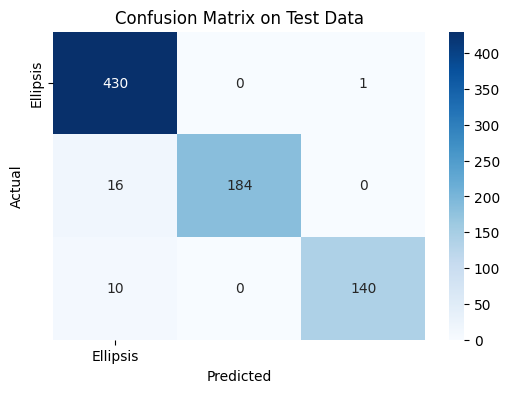

In [ ]:
import seaborn as sns
cm = confusion_matrix(actual, predicted)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[...], yticklabels=[...])  # Replace [...] with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Data')
plt.show()

Confusion Matrix:
 [[430   0   1]
 [ 16 184   0]
 [ 10   0 140]]


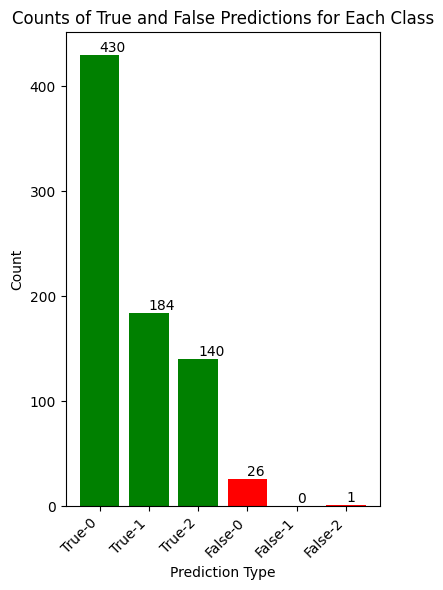

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assume test_true and test_preds are the true labels and predicted labels respectively
# Define class names based on the labels present in test_true and test_preds
class_names = np.unique(np.concatenate((actual, predicted)))

# Compute confusion matrix
cm = confusion_matrix(actual, predicted, labels=class_names)
print("Confusion Matrix:\n", cm)

# Extract counts from confusion matrix
true_positives = np.diag(cm)
false_positives = cm.sum(axis=0) - true_positives
false_negatives = cm.sum(axis=1) - true_positives

# Prepare data for bar graph
labels = [f'True-{cls}' for cls in class_names] + [f'False-{cls}' for cls in class_names]
counts = list(true_positives) + list(false_positives)

# Plot bar graph
plt.figure(figsize=(4, 6))
bars = plt.bar(labels, counts, color=['green']*len(class_names) + ['red']*len(class_names))
plt.title('Counts of True and False Predictions for Each Class')
plt.xlabel('Prediction Type')
plt.ylabel('Count')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('prediction_counts.png')
plt.show()


In [ ]:
report = classification_report(actual, predicted, output_dict=True)


In [ ]:
#class_names=['benign','malignant','normal']
class_names=['0','1','2']

In [ ]:
pre = []
re = []
f1s = []
classNumbers=[]
i=1
for w in class_names:
    pre.append(report[w]['precision'])
    re.append(report[w]['recall'])
    f1s.append(report[w]['f1-score'])
    classNumbers.append(i)
    i=i+1


# Convert lists to numpy arrays
pre = np.array(pre)
re = np.array(re)
f1s = np.array(f1s)

# Print the arrays
print("Precision:", pre)
print("Recall:", re)
print("F1 Score:", f1s)

Precision: [0.94298246 1.         0.9929078 ]
Recall: [0.99767981 0.92       0.93333333]
F1 Score: [0.96956032 0.95833333 0.96219931]


In [ ]:
classNumbers=['benign','malignant','normal']

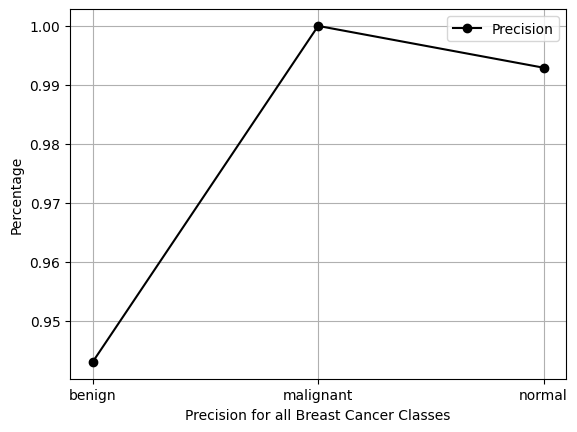

In [ ]:
import matplotlib.pyplot as plt


# Plot the loss values
plt.plot(classNumbers, pre, marker='o', linestyle='-', color='black', label='Precision')
plt.xlabel('Precision for all Breast Cancer Classes')
plt.ylabel('Percentage')
#plt.title('Percentage over Precision for Sign Language Recognition from Videos Frames')
plt.legend()
plt.grid(True)
plt.show()

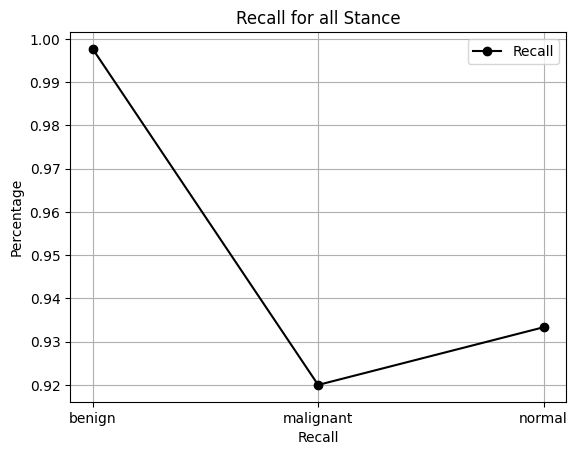

In [ ]:
plt.plot(classNumbers, re, marker='o', linestyle='-', color='black', label='Recall')
plt.xlabel('Recall')
title='Recall for all Breast Cancer Classes'
plt.ylabel('Percentage')
plt.title('Recall for all Stance')
plt.legend()
plt.grid(True)
plt.show()

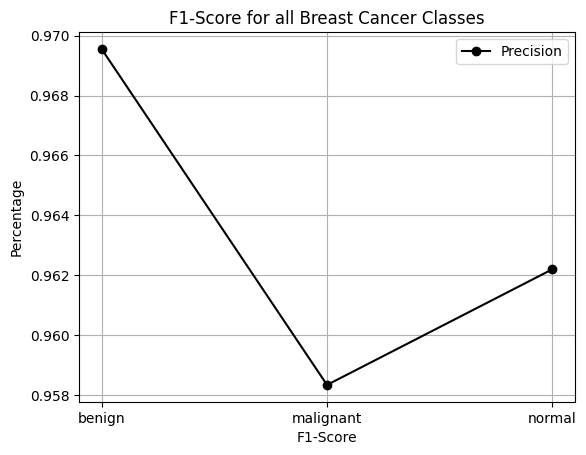

In [ ]:
plt.plot(classNumbers, f1s, marker='o', linestyle='-', color='black', label='Precision')
plt.xlabel('F1-Score')
title='F1-Score for all Stance'
plt.ylabel('Percentage')
plt.title('F1-Score for all Breast Cancer Classes')
plt.legend()
plt.grid(True)
plt.show()

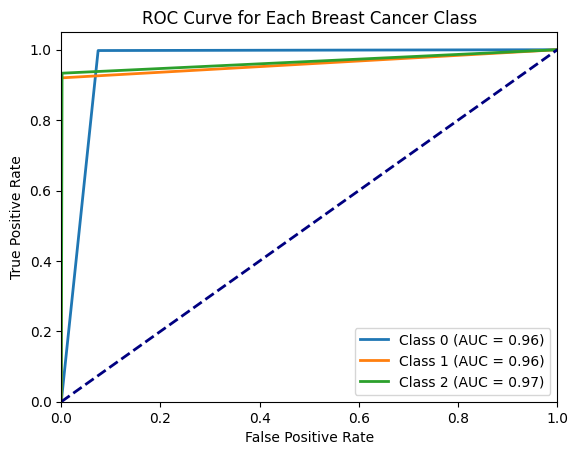

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Example arrays (replace these with your actual and predicted arrays)


# Binarize the output labels for multi-class
classes = np.unique(actual)
y_actual_bin = label_binarize(actual, classes=classes)
y_pred_bin = label_binarize(predicted, classes=classes)

# Compute ROC curve and ROC area for each class
plt.figure()
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_actual_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plotting details
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Breast Cancer Class')
plt.legend(loc='lower right')
plt.show()


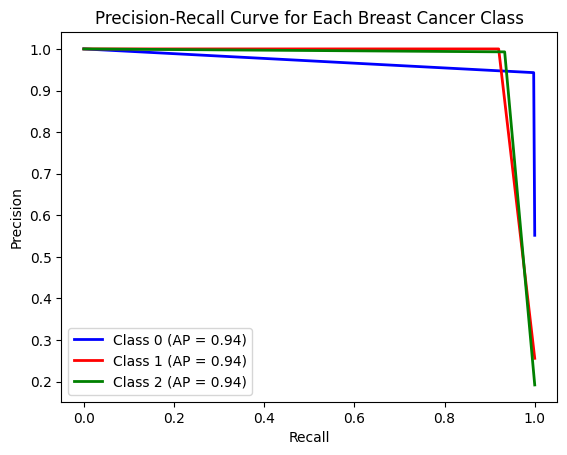

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle


# Binarize the output labels for multi-class
classes = np.unique(actual)
actual_bin = label_binarize(actual, classes=classes)
predicted_bin = label_binarize(predicted, classes=classes)

# Define colors for each class
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown'])

# Compute Precision-Recall curve and average precision for each class
plt.figure()
for i, color in zip(range(len(classes)), colors):
    precision, recall, _ = precision_recall_curve(actual_bin[:, i], predicted_bin[:, i])
    average_precision = average_precision_score(actual_bin[:, i], predicted_bin[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'Class {i} (AP = {average_precision:.2f})')

# Plotting details
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Breast Cancer Class')
plt.legend(loc='lower left')
plt.show()


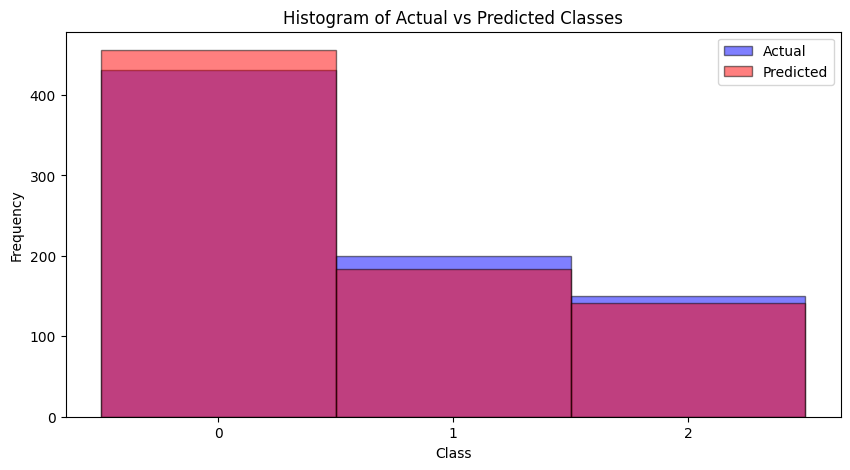

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Define the number of bins (one for each class)
bins = np.arange(len(np.unique(actual)) + 1) - 0.5

# Plot histograms for actual and predicted values
plt.figure(figsize=(10, 5))

# Histogram for the actual class distribution
plt.hist(actual, bins=bins, alpha=0.5, label='Actual', color='blue', edgecolor='black')

# Histogram for the predicted class distribution
plt.hist(predicted, bins=bins, alpha=0.5, label='Predicted', color='red', edgecolor='black')

# Plotting details
plt.xticks(np.arange(len(np.unique(actual))))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Actual vs Predicted Classes')
plt.legend(loc='upper right')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(actual, predicted)

print(f'Mean Absolute Error (MAE): {mae:.2f}')


Mean Absolute Error (MAE): 0.05


In [ ]:
mae

0.057

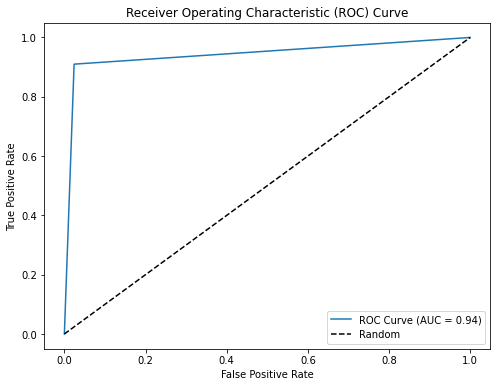

In [ ]:
import numpy as np
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(actual, predicted)

print(f'Matthews Correlation Coefficient (MCC): {mcc:.2f}')



Matthews Correlation Coefficient (MCC): 0.94


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.metrics import classification_report

# Load the CSV file
file_path = "/content/drive/MyDrive/BreastCancer/output/actualData.csv"
df = pd.read_csv(file_path)




In [5]:
# Extract actual and predicted values
actual = df["Actual"]
predicted = df["Predicted"]



In [4]:
# Generate classification report
report = classification_report(actual, predicted, target_names=["Benign", "Malignant", "Normal"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

      Benign       0.94      1.00      0.97       431
   Malignant       1.00      0.92      0.96       200
      Normal       0.99      0.93      0.96       150

    accuracy                           0.97       781
   macro avg       0.98      0.95      0.96       781
weighted avg       0.97      0.97      0.97       781



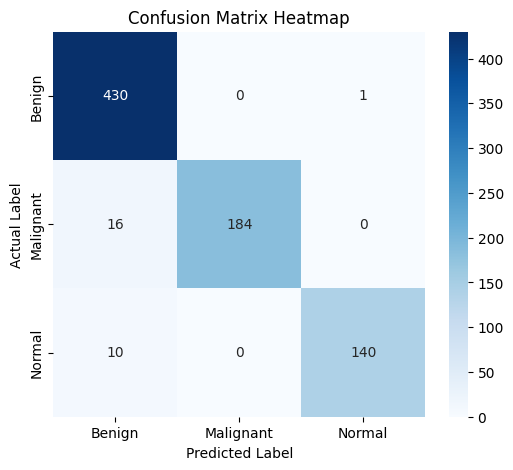

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predicted)

# Define class labels
class_labels = ["Benign", "Malignant", "Normal"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

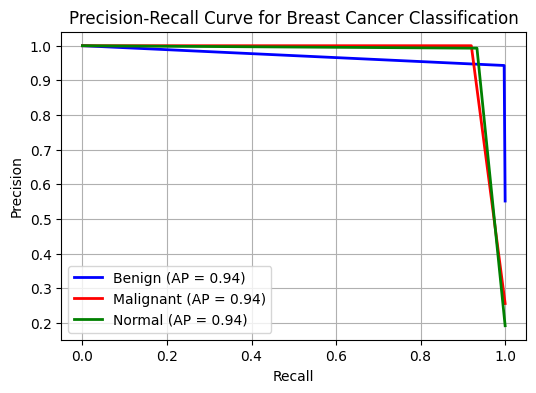

In [11]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Define class labels
class_labels = ["Benign", "Malignant", "Normal"]

# Convert actual and predicted values to NumPy arrays
actual = np.array(actual)
predicted = np.array(predicted)

# Binarize the output labels for multi-class classification
classes = np.unique(actual)
actual_bin = label_binarize(actual, classes=classes)
predicted_bin = label_binarize(predicted, classes=classes)

# Define colors for each class
colors = cycle(['blue', 'red', 'green'])

# Compute Precision-Recall curve and average precision for each class
plt.figure(figsize=(6, 4))
for i, (label, color) in enumerate(zip(class_labels, colors)):
    precision, recall, _ = precision_recall_curve(actual_bin[:, i], predicted_bin[:, i])
    average_precision = average_precision_score(actual_bin[:, i], predicted_bin[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'{label} (AP = {average_precision:.2f})')

# Plotting details
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Breast Cancer Classification')
plt.legend(loc='lower left')
plt.grid()
plt.show()


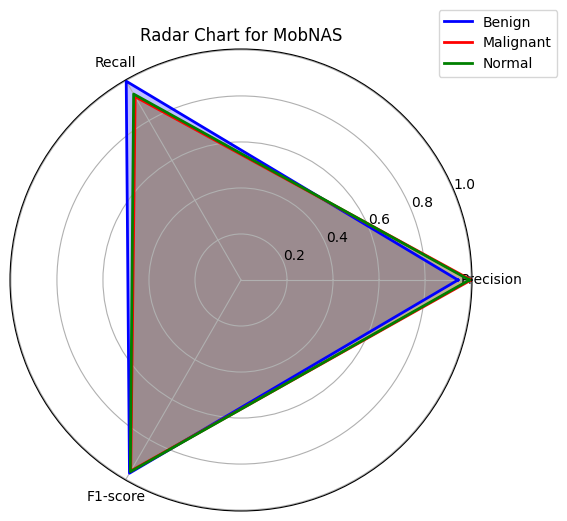

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(actual, predicted, target_names=["Benign", "Malignant", "Normal"], output_dict=True)

# Extract precision, recall, and F1-score for each class
labels = ["Benign", "Malignant", "Normal"]
metrics = ["Precision", "Recall", "F1-score"]

# Prepare data for each class
data = {
    "Benign": [report["Benign"]["precision"], report["Benign"]["recall"], report["Benign"]["f1-score"]],
    "Malignant": [report["Malignant"]["precision"], report["Malignant"]["recall"], report["Malignant"]["f1-score"]],
    "Normal": [report["Normal"]["precision"], report["Normal"]["recall"], report["Normal"]["f1-score"]],
}

# Number of metrics (3: Precision, Recall, F1-score)
num_vars = len(metrics)

# Create the angle values
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Create the Radar Chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Define colors for each class
colors = {'Benign': 'blue', 'Malignant': 'red', 'Normal': 'green'}

# Plot each class
for label, values in data.items():
    values += values[:1]  # Repeat the first value to close the circle
    ax.plot(angles, values, color=colors[label], linewidth=2, linestyle='solid', label=label)
    ax.fill(angles, values, color=colors[label], alpha=0.25)

# Labels & Legend
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("Radar Chart for MobNAS")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Show the plot
plt.show()


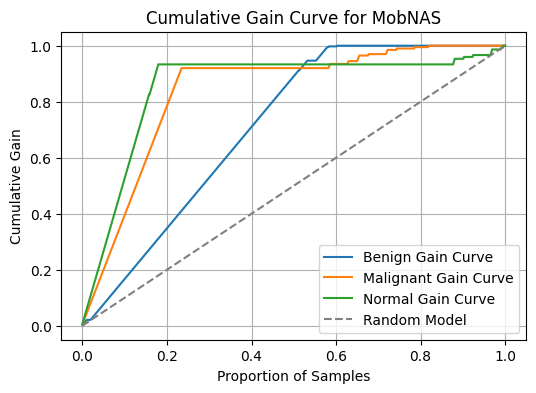

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Convert actual and predicted values into NumPy arrays
actual = np.array(actual)
predicted = np.array(predicted)

# Ensure the values are binary (0,1) for each class (One-vs-All)
class_labels = ["Benign", "Malignant", "Normal"]

plt.figure(figsize=(6, 4))

for i, label in enumerate(class_labels):
    # Convert to binary classification for each class
    y_true = (actual == i).astype(int)
    y_pred = (predicted == i).astype(int)

    # Sort by predicted probability
    sorted_indices = np.argsort(-y_pred)
    cumulative_gain = np.cumsum(y_true[sorted_indices]) / np.sum(y_true)

    # Plot Cumulative Gain Curve
    plt.plot(np.linspace(0, 1, len(cumulative_gain)), cumulative_gain, label=f"{label} Gain Curve")

# Reference diagonal for random model
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")

# Labels and formatting
plt.xlabel("Proportion of Samples")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve for MobNAS")
plt.legend()
plt.grid()
plt.show()


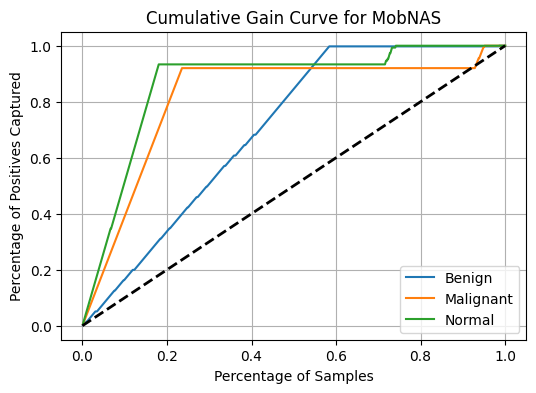

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def cumulative_gain(y_true, y_pred):
    sorted_indices = np.argsort(y_pred)[::-1]  # Sort by predicted probability
    sorted_y_true = y_true[sorted_indices]

    cumulative_gains = np.cumsum(sorted_y_true) / np.sum(sorted_y_true)  # Cumulative percentage
    percentages = np.arange(1, len(sorted_y_true) + 1) / len(sorted_y_true)  # Sample percentages

    return percentages, cumulative_gains

# Define class labels
class_labels = ["Benign", "Malignant", "Normal"]
plt.figure(figsize=(6, 4))

# Compute Cumulative Gain for each class
for i, label in enumerate(class_labels):
    y_true_class = (actual == i).astype(int)  # Convert to binary for each class
    y_pred_class = (predicted == i).astype(int)  # Use predicted class probabilities

    percentages, cumulative_gains = cumulative_gain(y_true_class, y_pred_class)
    plt.plot(percentages, cumulative_gains, label=label)

# Plotting details
plt.plot([0, 1], [0, 1], linestyle="--", color="black", lw=2)  # Random model reference
plt.xlabel("Percentage of Samples")
plt.ylabel("Percentage of Positives Captured")
plt.title("Cumulative Gain Curve for MobNAS")
plt.legend(loc="lower right")
plt.grid()
plt.show()


<ipython-input-15-c6bc545840d1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_classes, y=train_counts, palette='Blues')


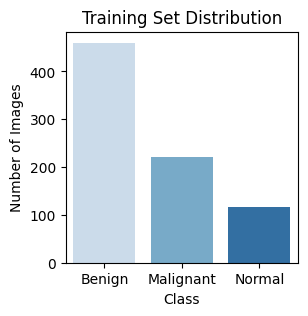

<ipython-input-15-c6bc545840d1>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_classes, y=test_counts, palette='Oranges')


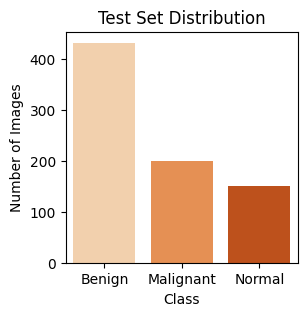

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for Training Set
train_classes = ['Benign', 'Malignant', 'Normal']
train_counts = [460, 221, 116]

# Data for Test Set
test_classes = ['Benign', 'Malignant', 'Normal']
test_counts = [431, 200, 150]

# Plot Training Set Distribution
plt.figure(figsize=(3, 3))
sns.barplot(x=train_classes, y=train_counts, palette='Blues')
plt.title('Training Set Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Plot Test Set Distribution
plt.figure(figsize=(3, 3))
sns.barplot(x=test_classes, y=test_counts, palette='Oranges')
plt.title('Test Set Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


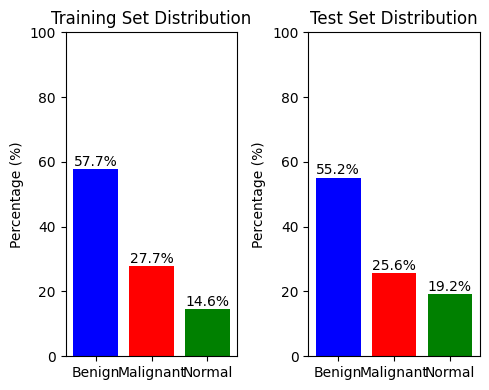

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Data
train_counts = np.array([460, 221, 116])
test_counts = np.array([431, 200, 150])
class_labels = ['Benign', 'Malignant', 'Normal']

# Convert counts to percentages
train_percent = (train_counts / train_counts.sum()) * 100
test_percent = (test_counts / test_counts.sum()) * 100

# Plot Training Set Distribution
plt.figure(figsize=(5,4))
plt.subplot(1, 2, 1)
plt.bar(class_labels, train_percent, color=['blue', 'red', 'green'])
plt.ylabel('Percentage (%)')
plt.title('Training Set Distribution')
plt.ylim(0, 100)
for i, v in enumerate(train_percent):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

# Plot Test Set Distribution
plt.subplot(1, 2, 2)
plt.bar(class_labels, test_percent, color=['blue', 'red', 'green'])
plt.ylabel('Percentage (%)')
plt.title('Test Set Distribution')
plt.ylim(0, 100)
for i, v in enumerate(test_percent):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()


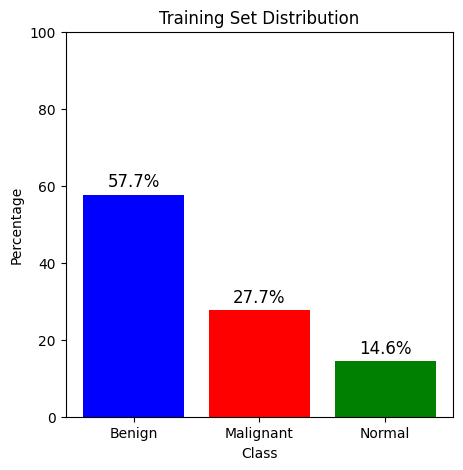

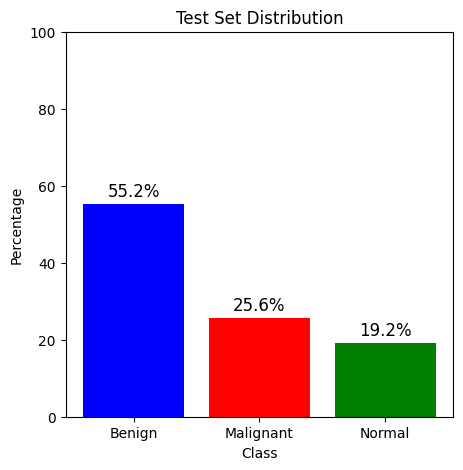

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Original counts
train_counts = {'Benign': 460, 'Malignant': 221, 'Normal': 116}
test_counts = {'Benign': 431, 'Malignant': 200, 'Normal': 150}

# Normalize to make total 100%
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())

train_percentages = {key: (value / total_train) * 100 for key, value in train_counts.items()}
test_percentages = {key: (value / total_test) * 100 for key, value in test_counts.items()}

# Plot training set distribution
plt.figure(figsize=(5, 5))
plt.bar(train_percentages.keys(), train_percentages.values(), color=['blue', 'red', 'green'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Training Set Distribution')
plt.ylim(0, 100)

# Annotate values
for i, v in enumerate(train_percentages.values()):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=12)

plt.show()

# Plot test set distribution
plt.figure(figsize=(5, 5))
plt.bar(test_percentages.keys(), test_percentages.values(), color=['blue', 'red', 'green'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Test Set Distribution')
plt.ylim(0, 100)

# Annotate values
for i, v in enumerate(test_percentages.values()):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=12)

plt.show()
